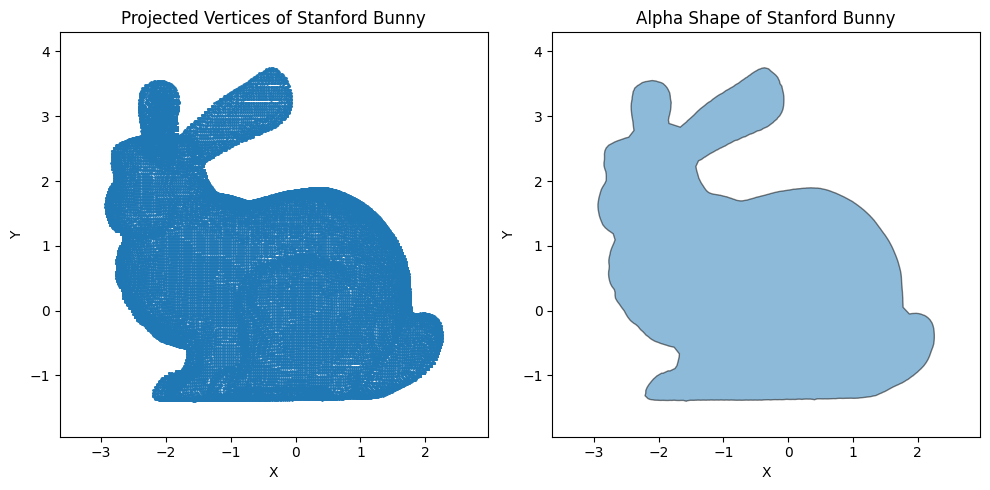

In [2]:
import trimesh
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import alphashape

bunny = trimesh.load("../Resources/stanford-bunny.obj")
vertices_2d = bunny.vertices[:, :2] * 50# Take only X and Y coordinates

#shift vertices to positive values
# min_x = np.min(vertices_2d[:, 0])
# min_y = np.min(vertices_2d[:, 1])
#vertices_2d[:, 0] -= min_x-1
#vertices_2d[:, 1] -= min_y-1

#shift vertices to be centered around 0,0
mean_x = np.mean(vertices_2d[:, 0])
mean_y = np.mean(vertices_2d[:, 1])
vertices_2d[:, 0] -= mean_x+1
vertices_2d[:, 1] -= mean_y-1
#scale vertices
vertices_2d = vertices_2d / 1.5



#print(vertices_2d)
#vertices_2d = vertices_2d * 30

alpha_shape = alphashape.alphashape(vertices_2d, 10)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*zip(*vertices_2d), s=1, label="Projected Vertices")
axs[0].set_title("Projected Vertices of Stanford Bunny")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")

#axs[0].set_xlim(-1, np.max(vertices_2d[:, 0])+1)
#axs[0].set_ylim(-1, np.max(vertices_2d[:, 1])+1)

#axs[1].scatter(*zip(*vertices_2d))
axs[1].add_patch(PolygonPatch(alpha_shape, alpha=0.5))
axs[1].set_title("Alpha Shape of Stanford Bunny")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
#axs[1].set_xlim(-1, np.max(vertices_2d[:, 0])+1)
#axs[1].set_ylim(-1, np.max(vertices_2d[:, 1])+1)

# axs[1].set_xlim(-10, 20)
# axs[1].set_ylim(-10, 20)

# Show the figure
plt.tight_layout()
plt.show()


In [ ]:
def bunny_sdf(vertices, obj_pc_fp="Resources/stanford-bunny.obj"):
    import trimesh
    import alphashape
    from shapely.geometry import Point, LineString    
    # Ray-casting to determine if the point is inside or outside
    def ray_casting(point, shape):
        import numpy as np
        from shapely.geometry import LineString, MultiLineString

        ray_length = 1000  # Length of the ray
        # Define all directions as a NumPy array
        directions = np.array([
            [ray_length, 0],   # Positive X
            [-ray_length, 0],  # Negative X
            [0, ray_length],   # Positive Y
            [0, -ray_length],  # Negative Y
            [ray_length, ray_length],  # Diagonal top-right
            [-ray_length, -ray_length]  # Diagonal bottom-left
        ])

        rays = [LineString([point, point + direction]) for direction in directions]

        intersections = [shape.boundary.intersection(ray) for ray in rays]

        # Compute the number of intersections for each ray
        intersection_counts = []
        for intersection in intersections:
            if intersection.geom_type == "Point":
                intersection_counts.append(1)
            elif intersection.geom_type == "MultiPoint":
                intersection_counts.append(len(intersection.geoms))
            else:  # No valid intersection
                intersection_counts.append(0)

        # Return the maximum number of intersections across all rays
        highest_intersections = max(intersection_counts)
        return highest_intersections
        
    bunny = trimesh.load(obj_pc_fp)
    bunny_2dvertices = bunny.vertices[:, :2] * 50 # Take only X and Y coordinates
    
    # #shift vertices to positive values
    # min_x = np.min(bunny_2dvertices[:, 0])
    # min_y = np.min(bunny_2dvertices[:, 1])
    # bunny_2dvertices[:, 0] -= min_x-1
    # bunny_2dvertices[:, 1] -= min_y-1
    
    #shift vertices to be centered around 0,0
    mean_x = np.mean(bunny_2dvertices[:, 0])
    mean_y = np.mean(bunny_2dvertices[:, 1])
    bunny_2dvertices[:, 0] -= mean_x+1
    bunny_2dvertices[:, 1] -= mean_y-1
    #scale vertices
    bunny_2dvertices = bunny_2dvertices / 1.5


    

    alpha_shape = alphashape.alphashape(bunny_2dvertices, 10)

    sdf_values = torch.zeros(vertices.shape[0])

    # Compute the signed distance for each vertices
    for i, point in enumerate(vertices):
        point_shapely = Point(point[0], point[1])
        
        # Compute the shortest distance to the boundary
        distance_to_boundary = point_shapely.distance(alpha_shape.boundary)
        
        # Use ray-casting to determine if the point is inside or outside
        if ray_casting(point, alpha_shape) % 2 == 1:
            sdf_values[i] = -distance_to_boundary  # Inside, negative distance
        else:
            sdf_values[i] = distance_to_boundary  # Outside, positive distance


    return sdf_values



In [ ]:
import matplotlib
import os
import numpy as np
import torch

# Grid size
gridsize = 1024

# Create a grid of points (for example, a 100x100 grid within the bounding box of the alpha shape)
x_min, y_min, x_max, y_max = alpha_shape.bounds# Assuming `alpha_shape` is already defined

x_min = x_max*-7
y_min = y_max*-5
x_max = x_max*7
y_max = y_max*5

grid_x, grid_y = torch.meshgrid(
    torch.linspace(x_min, x_max, gridsize),
    torch.linspace(y_min, y_max, gridsize),
    indexing="ij"  # Match the shape of `meshgrid` in NumPy
)

# Flatten the grid to create input points
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)  # Shape: (gridsize^2, 2)


# Example: Compute signed distance for the grid points
sdf_grid_path = f"sdf_grid_{gridsize}_centered.pt"

if not os.path.exists(sdf_grid_path):
    sdf_values = bunny_sdf(grid_points)
    # Reshape the SDF values back to the grid for visualization
    sdf_grid = sdf_values.view(gridsize, gridsize)
    torch.save(sdf_grid, sdf_grid_path)
else:
    sdf_grid = torch.load(sdf_grid_path)


print(sdf_grid)
print(sdf_grid.shape)

# Optionally, convert to NumPy for plotting
sdf_grid_np = sdf_grid.cpu().numpy()


# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
#norm = matplotlib.colors.Normalize(vmin=np.min(sdf_grid_np), vmax=-np.min(sdf_grid_np))
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_grid_np), vcenter=0, vmax=np.max(sdf_grid_np))



# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, sdf_grid_np, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, sdf_grid_np, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")

# Show the plot
plt.show()

In [ ]:
import torch

def interpolate_sdf(grid, points, x_min, y_min, x_max, y_max):
    """
    Interpolate SDF values for given 2D points using a precomputed SDF grid.
    Args:
        grid: SDF grid of shape (gridsize, gridsize).
        points: Input points of shape (N, 2), where each row is (x, y).
        x_min, y_min, x_max, y_max: Bounds of the grid.
    Returns:
        Interpolated SDF values at the input points of shape (N,).
    """
    # Normalize points to [0, 1] range
    points_normalized = (points - torch.tensor([x_min, y_min])) / torch.tensor([x_max - x_min, y_max - y_min])

    # Scale to grid coordinates
    gridsize = grid.shape[0]
    points_grid = points_normalized * (gridsize - 1)

    # Separate grid coordinates into integer and fractional parts
    x = points_grid[:, 0]
    y = points_grid[:, 1]
    x0 = x.floor().long().clamp(0, gridsize - 1)
    y0 = y.floor().long().clamp(0, gridsize - 1)
    x1 = (x0 + 1).clamp(0, gridsize - 1)
    y1 = (y0 + 1).clamp(0, gridsize - 1)
    dx = x - x0
    dy = y - y0

    # Perform bilinear interpolation
    values = (
        (1 - dx) * (1 - dy) * grid[x0, y0] +
        dx * (1 - dy) * grid[x1, y0] +
        (1 - dx) * dy * grid[x0, y1] +
        dx * dy * grid[x1, y1]
    )
    return values

# # Example usage
# points = torch.tensor([[0.1, 0.2], [0.3, 0.4]])  # Example 2D input points
# interpolated_sdf = interpolate_sdf(sdf_grid, points, x_min, y_min, x_max, y_max)
# print(interpolated_sdf)



# Grid size
gridsize = 100

# Create a grid of points (for example, a 100x100 grid within the bounding box of the alpha shape)
x_min, y_min, x_max, y_max = alpha_shape.bounds  # Assuming `alpha_shape` is already defined

x_min = x_max*-1.5
y_min = y_max*-1.5
x_max = x_max*2
y_max = y_max*2

grid_x, grid_y = torch.meshgrid(
    torch.linspace(x_min, x_max, gridsize),
    torch.linspace(y_min, y_max, gridsize),
    indexing="ij"  # Match the shape of `meshgrid` in NumPy
)

# Flatten the grid to create input points
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)  # Shape: (gridsize^2, 2)




interpolated_sdf = interpolate_sdf(sdf_grid, grid_points, x_min, y_min, x_max, y_max)

# Reshape the SDF values back to the grid for visualization
interpolate_sdf_grid = interpolated_sdf.view(gridsize, gridsize)

print(interpolate_sdf_grid)
print(interpolate_sdf_grid.shape)

# Optionally, convert to NumPy for plotting
sdf_grid_np = interpolate_sdf_grid.cpu().numpy()


# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_grid_np),vcenter=0, vmax=np.max(sdf_grid_np))

# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, sdf_grid_np, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, sdf_grid_np, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
# Show the plot
plt.show()

In [ ]:
print(x_min, y_min, x_max, y_max)

### 3D  grid to use for "true" sdf

In [13]:
from mesh_to_sdf import sample_sdf_near_surface
import torch
import trimesh
import pyrender
import numpy as np

mesh = trimesh.load("../Resources/dolphin.obj")


points, sdf = sample_sdf_near_surface(mesh, number_of_points=10000)

points *= 4
sdf *= 4

colors = np.zeros(points.shape)
colors[sdf < 0, 2] = 1
colors[sdf > 0, 0] = 1
cloud = pyrender.Mesh.from_points(points, colors=colors)
scene = pyrender.Scene()
scene.add(cloud)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)



# Show point with values in polyscope
import polyscope as ps
ps.init()
ps_cloud = ps.register_point_cloud("points", points)
ps_cloud.add_scalar_quantity("sdf", sdf)
ps.show()
# import numpy as np
# import trimesh
# from scipy.spatial import cKDTree

# # Load mesh and preprocess
# bunny = trimesh.load("../Resources/stanford-bunny.obj")
# bbox = bunny.bounding_box.bounds


# # Sample SDF values
# grid_points, grid_sdf = sample_sdf_near_surface(bunny, number_of_points=250000)


# # Get current bounding box
# min_bound = bunny.bounds[0]  # Min (x, y, z)
# max_bound = bunny.bounds[1]  # Max (x, y, z)

# # Compute scale factor
# current_size = max_bound - min_bound  # Size in each dimension
# target_size = 8  # Because we want [-5, 5], the total size is 10

# scale_factor = target_size / np.max(current_size)  # Scale based on the largest dimension

# # Compute new center after scaling
# new_vertices = bunny.vertices * scale_factor  # Scale the vertices
# new_min = np.min(new_vertices, axis=0)
# new_max = np.max(new_vertices, axis=0)
# new_center = (new_min + new_max) / 2  # New center after scaling

# # Compute translation to center the bunny at (0,0,0)
# translation = -new_center  # Move to the origin

# # Apply transformation (scaling + translation)
# bunny.vertices = new_vertices + translation

# #target_points = bunny.sample(16*16*16)
# target_points = bunny.sample(16*16*16*8)
# target_points = torch.tensor(target_points)

# min_target = target_points.min(0)[0]
# max_target = target_points.max(0)[0]
# print(min_target, max_target)


# grid_points, grid_sdf = sample_sdf_near_surface(bunny, number_of_points=250000)
# grid_points = torch.tensor(grid_points)
# grid_sdf = torch.tensor(grid_sdf)
# min_grid = grid_points.min(0)[0]
# max_grid = grid_points.max(0)[0]

# scale = max((max_target - min_target) / (max_grid - min_grid))
# print(scale)

# grid_points = grid_points * scale
# grid_sdf = grid_sdf * scale

    

In [ ]:
import numpy as np
import trimesh
from scipy.spatial import KDTree

# Load mesh and preprocess
bunny = trimesh.load("../Resources/stanford-bunny.obj")
sites = bunny.vertices[:, :3] * 50

# Sample SDF values
grid_points, grid_sdf = sample_sdf_near_surface(bunny, number_of_points=250000)




# Normalize input points to fit inside unit sphere
sites = (sites - np.mean(sites, axis=0)) / np.max(np.linalg.norm(sites, axis=1))

# Build a KD-tree for fast nearest-neighbor lookup
tree = KDTree(grid_points)

# Query 3 nearest neighbors
k = 3
distances, indices = tree.query(sites, k=k)

# Retrieve corresponding SDF values
sdf_values = grid_sdf[indices]

In [9]:
#test from mesh2sdf
import os
import sys
import trimesh
import mesh2sdf
import numpy as np
import time
import pyrender


filename = "../Resources/stanford-bunny.obj"


mesh_scale = 0.8
size = 128
level = 2 / size

mesh = trimesh.load(filename, force='mesh')
scale = 2

# normalize mesh
vertices = mesh.vertices
bbmin = vertices.min(0)
print(bbmin)
bbmax = vertices.max(0)
print(bbmax)
center = (bbmin + bbmax) * 0.5
print(center)
#scale = 1.0 * mesh_scale / (bbmax - bbmin).max()
scale = vertices.max(0) - vertices.min(0)
scale = 1 / scale.max()
print(scale)
vertices = (vertices - center) * scale
print(vertices.min(0))
print(vertices.max(0))

#show bunny
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh))
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)   

[-0.09469   0.032987 -0.061874]
[0.061009 0.187321 0.0588  ]
[-0.0168405  0.110154  -0.001537 ]
6.422648828829986
[-0.5        -0.49561654 -0.38752336]
[0.5        0.49561654 0.38752336]


In [10]:
# fix mesh
t0 = time.time()
sdf, mesh = mesh2sdf.compute(
    vertices, mesh.faces, size, fix=True, level=level, return_mesh=True)
t1 = time.time()
sdf = sdf * scale
print(sdf.min(), sdf.max())
# output
#mesh.vertices = mesh.vertices / scale + center
print(mesh.vertices.min(0))
print(mesh.vertices.max(0))
mesh.export(filename[:-4] + '.fixed.obj')
np.save(filename[:-4] + '.npy', sdf)
print('It takes %.4f seconds to process %s' % (t1-t0, filename))


#show bunny
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh))
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)   

-0.2007757 8.934244
[-0.51529208 -0.51073137 -0.40211833]
[0.51516557 0.51050007 0.40299451]
It takes 11.4012 seconds to process ../Resources/stanford-bunny.obj


In [11]:
#load npy
sdf = np.load(filename[:-4] + '.npy')
print(sdf.shape)


(128, 128, 128)


In [71]:
#visualiser from mesh2sdf
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure
import trimesh

#filename = "../Resources/stanford-bunny.npy"


mesh_scale = 0.8
levels = [-0.02, 0.0, 0.02]

folder = filename[:-4]
if not os.path.exists(folder):
  os.makedirs(folder)

sdf = np.load(filename)
size = sdf.shape[0]
print(sdf.max(), sdf.min())

# extract level sets
for i, level in enumerate(levels):
  vtx, faces, _, _ = skimage.measure.marching_cubes(sdf, level)

  vtx = vtx * (mesh_scale * 2.0 / size) - 1.0
  mesh = trimesh.Trimesh(vtx, faces)
  mesh.export(os.path.join(folder, 'l%.2f.obj' % level))


# draw image
for i in range(size):
  array_2d = sdf[:, :, i]

  num_levels = 6
  fig, ax = plt.subplots(figsize=(2.75, 2.75), dpi=300)
  levels_pos = np.logspace(-2, 0, num=num_levels)  # logspace
  levels_neg = -1. * levels_pos[::-1]
  levels = np.concatenate((levels_neg, np.zeros((0)), levels_pos), axis=0)
  colors = plt.get_cmap("Spectral")(np.linspace(0., 1., num=num_levels*2+1))

  sample = array_2d
  # sample = np.flipud(array_2d)
  CS = ax.contourf(sample, levels=levels, colors=colors)

  ax.contour(sample, levels=levels, colors='k', linewidths=0.1)
  ax.contour(sample, levels=[0], colors='k', linewidths=0.3)
  ax.axis('off')

  plt.savefig(os.path.join(folder, '%03d.png' % i))
  # plt.show()

ValueError: Cannot load file containing pickled data when allow_pickle=False